# Parameter Values

In this notebook, we explain how parameter values are set for a model.

## Setting up parameter values

In [1]:
%matplotlib inline
import pybamm
import tests
import numpy as np
import os
import matplotlib.pyplot as plt
from pprint import pprint
os.chdir(pybamm.__path__[0]+'/..')

In `pybamm`, the object that sets parameter values for a model is the `ParameterValues` class, which extends `dict`. This takes the values of the parameters as input, which can be either a dictionary,

In [2]:
param_dict = {"a": 1, "b": 2, "c": 3}
parameter_values = pybamm.ParameterValues(param_dict)
print("parameter values are {}".format(parameter_values))

parameter values are {'a': 1, 'b': 2, 'c': 3}


or a csv file,

In [3]:
%%writefile input/param_file.csv
Name,Value
a, 4
b, 5
c, 6

Overwriting input/param_file.csv


In [4]:
parameter_values = pybamm.ParameterValues("input/param_file.csv")
print("parameter values are {}".format(parameter_values))

parameter values are {'a': 4, 'b': 5, 'c': 6}


We can also input functions into the parameter values, by providing either the path to the function or just a name (in which case the whole directory is searched)

In [5]:
%%writefile input/squared.py
def squared(x):
    return x ** 2

Overwriting input/squared.py


In [6]:
parameter_values = pybamm.ParameterValues("input/param_file.csv", {"my function": "squared.py"})
print("parameter values are {}".format(parameter_values))

parameter values are {'a': 4, 'b': 5, 'c': 6, 'my function': 'squared.py'}


## Setting parameters for an expression

We represent parameters in models using the classes `Parameter` and `FunctionParameter`. These cannot be evaluated directly,

In [7]:
a = pybamm.Parameter("a")
b = pybamm.Parameter("b")
c = pybamm.Parameter("c")
func = pybamm.FunctionParameter("my function", a)

expr = a + b * c
expr.evaluate()

NotImplementedError: method self.evaluate() not implemented
               for symbol a of type <class 'pybamm.expression_tree.parameter.Parameter'>

However, the `ParameterValues` class can walk through an expression, changing an `Parameter` objects it sees to the appropriate `Scalar` and any `FunctionParameter` object to the appropriate `Function`, and the resulting expression can be evaluated

In [8]:
expr_eval = parameter_values.process_symbol(expr)
print("{} = {}".format(expr_eval, expr_eval.evaluate()))

a + b * c = 34.0


In [9]:
func_eval = parameter_values.process_symbol(func)
print("{} = {}".format(func_eval, func_eval.evaluate()))

function (squared)(a) = 16.0


We can also update an expression using a new set of parameter values (e.g. for parameter fitting). Note that any parameter values not included in `new_parameter_values` remain unchanged.

In [10]:
new_parameter_values = pybamm.ParameterValues({"a": 2})

expr_eval_update = new_parameter_values.update_scalars(expr_eval)
print("{} = {}".format(expr_eval_update, expr_eval_update.evaluate()))

func_eval_update = new_parameter_values.update_scalars(func_eval)
print("{} = {}".format(func_eval_update, func_eval_update.evaluate()))

a + b * c = 32.0
function (squared)(a) = 4.0


## Solving a model

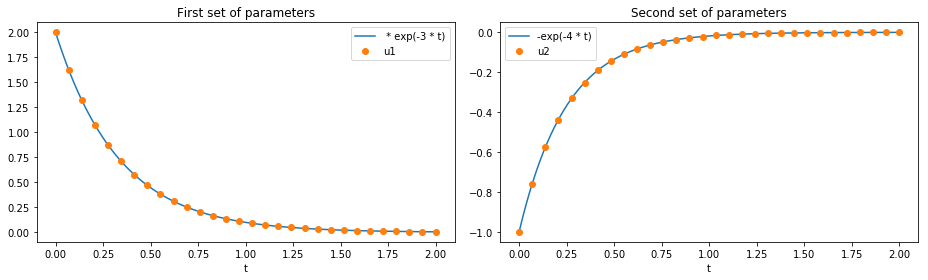

In [11]:
# Create model
model = pybamm.BaseModel()
u = pybamm.Variable("u")
a = pybamm.Parameter("a")
b = pybamm.Parameter("b")
model.rhs = {u: -a * u}
model.initial_conditions = {u: b}
model.variables = {"u": u}

# Set parameters ############################################
parameter_values = pybamm.ParameterValues({"a": 3, "b": 2})
parameter_values.process_model(model)
#############################################################

# Discretise using default discretisation
disc = tests.StandardModelTest(model).disc
disc.process_model(model)

# Solve
t_eval = np.linspace(0, 2, 30)
ode_solver = pybamm.ScikitsOdeSolver()
ode_solver.solve(model, t_eval)

# Post-process, so that u1 can be called at any time t (using interpolation)
t_sol1, y_sol1 = ode_solver.t, ode_solver.y
u1 = pybamm.ProcessedVariable(model.variables["u"], t_sol1, y_sol1)

# Update parameters and solve again ###############################
new_parameter_values = pybamm.ParameterValues({"a": 4, "b": -1})
new_parameter_values.update_model(model, disc) # no need to re-discretise
ode_solver.solve(model, t_eval)
t_sol2, y_sol2 = ode_solver.t, ode_solver.y
u2 = pybamm.ProcessedVariable(model.variables["u"], t_sol2, y_sol2)
###################################################################

# Plot
t_fine = np.linspace(0,t_eval[-1],1000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4))
ax1.plot(t_fine, 2 * np.exp(-3 * t_fine), t_sol1, u1(t_sol1)[0], "o")
ax1.set_xlabel("t")
ax1.legend([" * exp(-3 * t)", "u1"], loc="best")
ax1.set_title("First set of parameters")

ax2.plot(t_fine, - np.exp(-4 * t_fine), t_sol2, u2(t_sol2)[0], "o")
ax2.set_xlabel("t")
ax2.legend(["-exp(-4 * t)", "u2"], loc="best")
ax2.set_title("Second set of parameters")


plt.tight_layout()
plt.show()